# NEURO EXAM
## Own Experiment - EEG Preprocessing

Work flow for this preprocessing:
- Eye ballling the data to exclude obvious bad channels 
- Filtering (high and low pass) 
- ICA
- Artefact detection (rejecting all data that are likely not brain signal)
- Triggers and Epoching
- Downsampling (epochs)
- Plotting single trial epochs
- Plotting evoked plots (averaged epochs) 


In [88]:
%%capture

# importing packages 
import os
import pip
os.system('python -m pip install mne')
os.system('python -m pip install scikit-learn')
import numpy as np
import mne
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

In [170]:
# read data
sample_data_folder = ("/work/58044/Group3/") # /work/ er mit default overmappe
sample_data_raw_file = os.path.join(sample_data_folder,'Group3_own.vhdr')
raw = mne.io.read_raw_brainvision(sample_data_raw_file, eog=('EOG1', 'EOG2'))

#inspecting the data
raw.load_data()

# Making a copy of real raw data, for later applying ICA
real_raw = raw.copy()

Extracting parameters from /work/58044/Group3/Group3_own.vhdr...
Setting channel info structure...
Reading 0 ... 751859  =      0.000 ...   751.859 secs...


In [171]:
#setting reference to a common average
raw.set_eeg_reference('average', projection=False, verbose=False)

#also on real raw
real_raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

## Inspecting data in a raw state
Plotting 30 seconds of 32 channels, using scalings (makes it easier to distinguish between  the signals) 


Opening raw-browser...


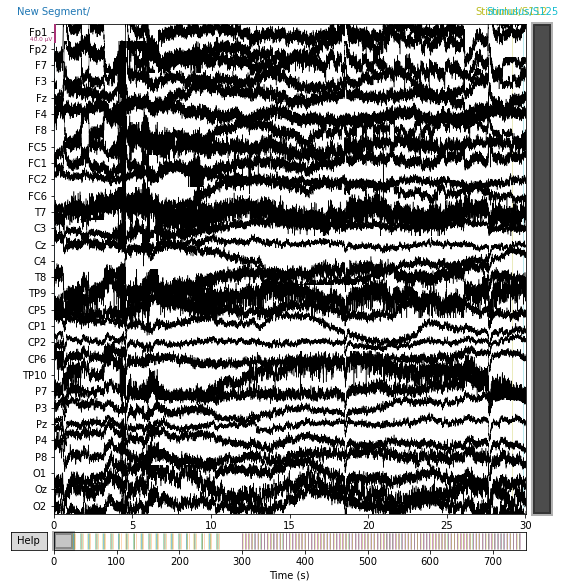

In [142]:
# Raw plot without any scalings
eeg_channels = mne.pick_types(raw.info, eeg= True)
raw.plot(duration=30, order=eeg_channels, n_channels=len(eeg_channels),
         remove_dc=True);


Opening raw-browser...


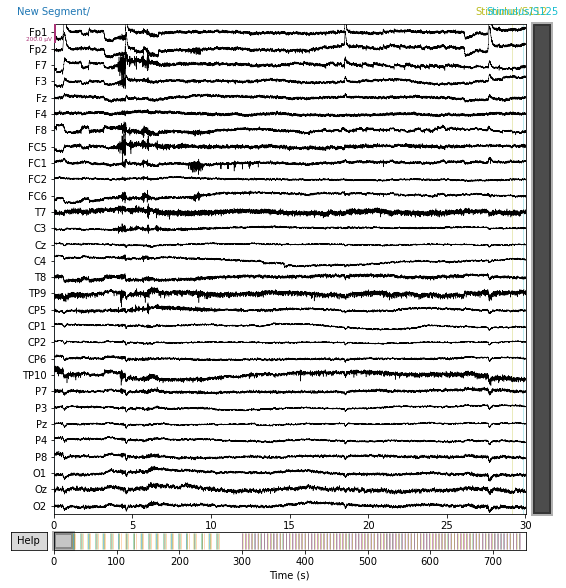

In [143]:
# Plot of raw data using scalings (this is way better)
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot(duration = 30, n_channels = 32, scalings = dict(eeg=0.00010),show_first_samp= True); 

## Excluding bad channels

Looks like none of the channels are catastrophically bad, so we continue with the work flow.

## Selecting standard 10-20 system
This is very default to do. Also plotting the EEG cap.

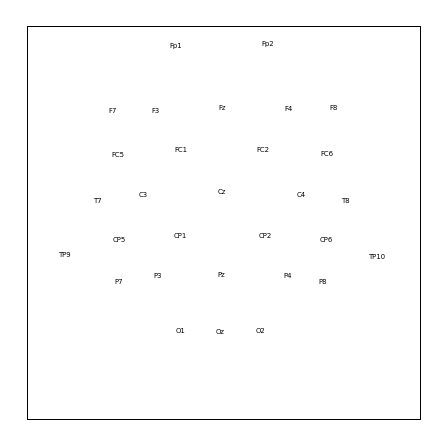

In [144]:
##Specify the channel locations using the montage-related functions: 
montage = mne.channels.make_standard_montage('standard_1020') #we're using the 10-20 standard method
raw.set_montage(montage, verbose=False)
real_raw.set_montage(montage, verbose=False)

#plot of electrodes
electrodes = mne.channels.make_eeg_layout(raw.info, radius=0.5, width=None, height=None, csd=False)
electrodes.plot();

## Filtering
We high-pass filter the data at 0.1 Hz and low-pass filter the data at 40 Hz, following the typical practices of EEG preprocessing. The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts)), with frequencies higher than the frequencies of the signal we are interested in.

We filter before we run the ICA. This is an important step to remove low-frequency drifts, which can negatively affect the quality of the ICA fit. The slow drifts are problematic because they reduce the independence of the assumed-to-be-independent sources (e.g., during a slow upward drift, the neural, heartbeat, blink, and other muscular sources will all tend to have higher values), making it harder for the algorithm to find an accurate solution. A high-pass filter with 1 Hz cutoff frequency is recommended. However, because filtering is a linear operation, the ICA solution found from the filtered signal can be applied to the unfiltered signal (see 2 for more information), so we’ll keep a copy of the unfiltered Raw object around so we can apply the ICA solution to it later.
Source: (https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Opening raw-browser...


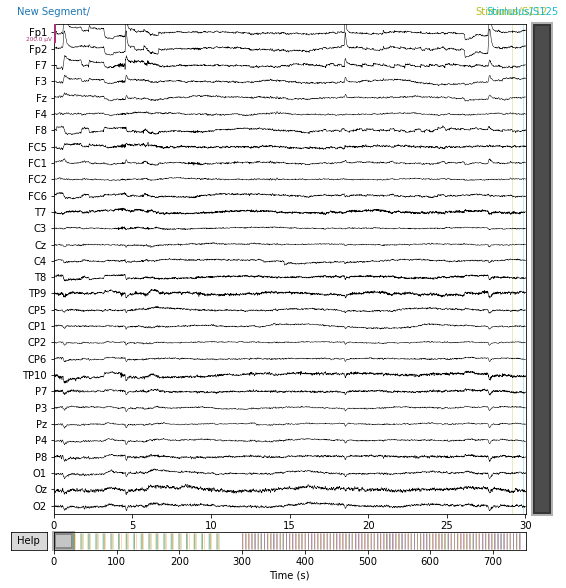

In [145]:
#Filter your data (highpass; 0.1 Hz; lowpass: 40 Hz);
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None) #high-pass filtering
raw = raw.filter(None, 40) #low-pass filtering

# plotting the filtered data for inspection
raw.plot(duration = 30, n_channels = 32, scalings = dict(eeg=0.00010),show_first_samp= True); 

## ICA (Independent Component Analysis)
Independent Component Analysis (ICA) is used to filter out artifacts from the signal (approach to repair artifacts) . The benefits of using ICA are the most apparent when multi-channel signal is recorded, thus this is performed at the signal preprocessing stage in the EEG analysis of this experiment. 

In [146]:
# Setting seed (1) and iterations (default auto)
# n_components=0.95 = amount of components explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=1, max_iter= 100)
ica.fit(raw)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components


/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 28.3s.


Method,fastica
Fit,100 iterations on raw data (751860 samples)
ICA components,12
Explained variance,95.5 %
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


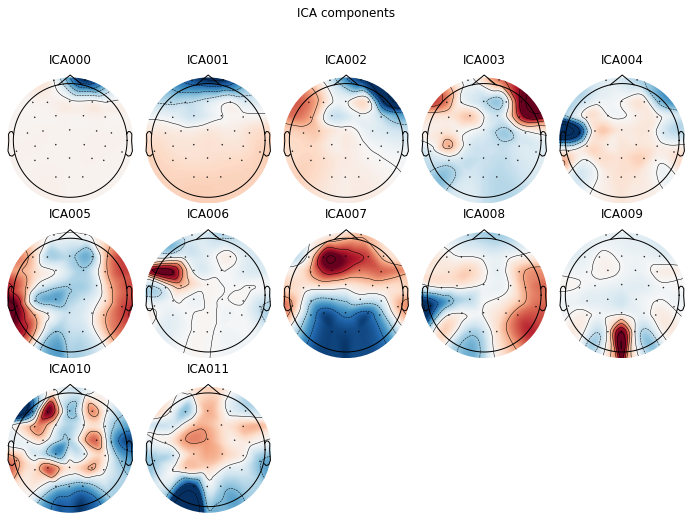

In [147]:
#Plotting each component in a topography
ica.plot_components();

Using the source below, we exclude some of the 12 components, since they seem to contain noise signals. 
For instance ICA000 may contain noise from eye blinks, as the signal is mainly located anterior close to the eyes. 

Source: (https://www.researchgate.net/figure/Typical-topoplot-image-patterns-of-different-artifact-types_fig1_316894381) 

Creating RawArray with float64 data, n_channels=12, n_times=751860
    Range : 0 ... 751859 =      0.000 ...   751.859 secs
Ready.
Opening ica-browser...


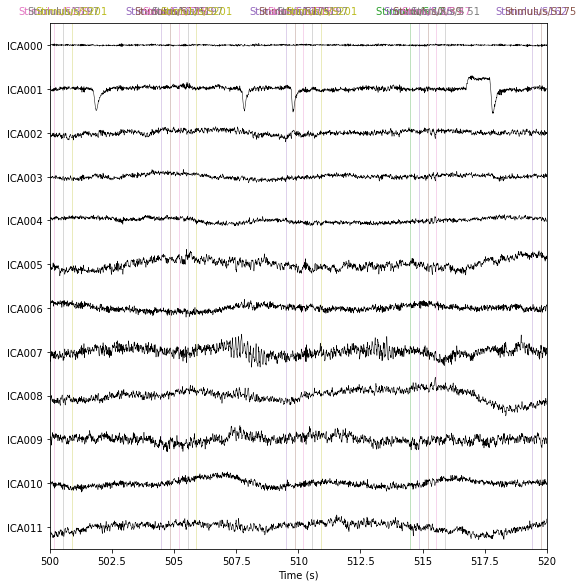

In [148]:
#Plotting in a time series of ica  (to look at the components in more detail)
ica.plot_sources(raw, show_scrollbars=False, start= 500, stop= 520);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


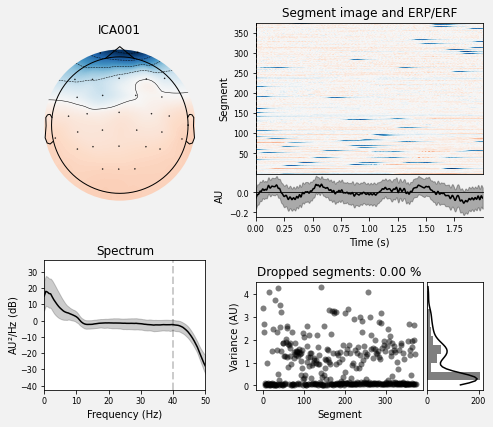

In [149]:
# Excluding components
# ICA001 seem to contain eye blinks
ica.exclude = [1]

ica.plot_properties(raw, picks=[1]);

### Applying ICA

In [150]:
# using ica on the REAL data
ica.apply(real_raw)

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Opening raw-browser...


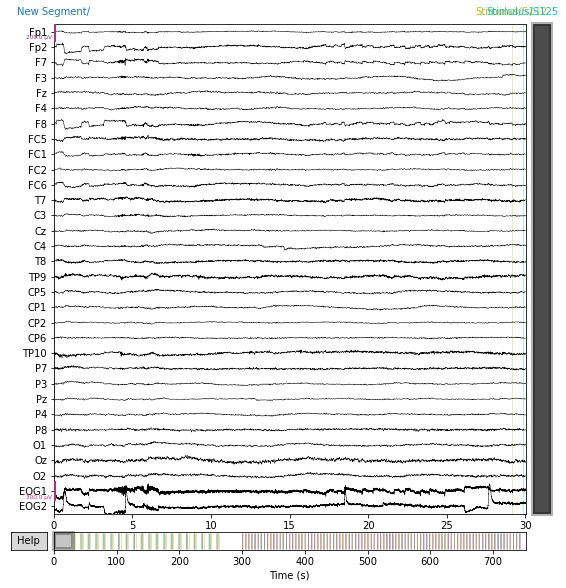

In [151]:
#filter on the ica version of real_raw
real_raw.filter(0.1, None) #high-pass filtering
real_raw.filter(None, 40) #low-pass filtering

# plotting the ica and filtered data.
real_raw.plot(duration = 30, n_channels = 32, scalings = dict(eeg=0.00010),show_first_samp= True); 

We could potentially exclude EOG1 and EOG2, but we are not gonna use them in the analysis anyway. So for now, we let them sit.

In [152]:
#trying to exclude EOG1 and EOG2 for analytical purposes
#real_raw.info['bads'] = ['EOG1', 'EOG2']# excluding a EEG_053 channel #removing it, cuz its dead

## Artefact detection
I select a value and reject anything above or below that value, in order to determine values over or under this threshold that are likely not related to brain activity.

In [153]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
reject = dict(eeg=150e-6)

# Triggers
First triggers are constructed

In [154]:
triggers, triggers_list = mne.events_from_annotations(real_raw)

np.shape(triggers) # number of triggers in orig triggers-structure

# read in trig_list - triggers from logfile
trig_list = np.genfromtxt('/work/58044/Group3/trig_list.csv', delimiter=',')


# number of triggers in that list
print(np.shape(trig_list))

# aligning first 10 triggers of both structures
[triggers[0:10,2], trig_list[0:10]]

# making a copy of our trig_list (except 1st nan-trigger) and setting trigger-99 to 6 in order to be able to compare 
# the training-set-triggers directly with our EEG-triggers
trig_list_temp = trig_list[1:].copy()
trig_list_temp = trig_list_temp.astype(int)
trig_list_temp[trig_list_temp==99] = 6
# also a copy of the 3rd column of the triggers-structure (except 1st 99999-trigger)
triggers_temp = triggers[1:,2].copy()
triggers_temp = triggers_temp % 10 # % means modulo - it's an operator that allows you to get the "rest" number after having divided with a given number (here 10)
# comparing the first 10 triggers of both temp-structures
(triggers_temp[0:10], trig_list_temp[0:10])


# getting the index of the first trigger that's not part of the learning phase (and we start from index 1 because or temp-structures don't include the first pseudo-trial)
learn_phase = np.argmax((triggers[1:,2]>151) | (triggers[1:,2]<112) & (triggers[1:,2]!=6))
# testing whether all triggers of the two vectors correspond from the beginning till then
all(triggers_temp[0:learn_phase]==trig_list_temp[0:learn_phase])

# THIS IS THE CRUCIAL STEP in creating and adapted triggers-structure:
# the logic is that for any values AFTER the learning phase, we simply subtract the modulo-values in triggers-temp from the triggers
# (cuz the trigger-temp-values are equivalent to the "ones" from the triggers-structure), and then we add the values from the logfile
new_triggers = triggers.copy()
new_triggers[learn_phase+1:,2] = new_triggers[learn_phase+1:,2]-triggers_temp[learn_phase:]+trig_list_temp[learn_phase:]


new_triggers[:,2] # just having a quick look at the "new" trigger-values


# THIS IS WHERE WE RECODE THE TRIGGERS
# Now we want to be able to tell all the different incorrect sequences from each other
# And we know that they ALL uniquely start with 162 (cuz that's always the first number in an incrorrect sequence)
# And we also know that if the second trigger is 175 and third is not 189, then it's a sequence that is incorrect from its third place onwards (and then we add 50 to all triggers in those sequences)
# Same logic if the second and third triggers are 175 and 189, resp., and fourth is not 197, then it's a sequence that it's incorrect from its fourth place onwards (we add 100 to those)
# Same logic if the second to fourth triggers are 175, 189, 197 resp., and fifth is not 201, then it's a sequence that it's incorrect from its fifth place onwards (we add 150 to those)
incorr_idx = new_triggers[:,2] == 162 # getting a boolean index
incorr_rows = [i for i, x in enumerate(incorr_idx) if x] # getting the actual trial-numbers to have something to loop over
print(len(incorr_rows))
for i in incorr_rows:
    if (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]!=189):
        #print('third')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+50
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]!=197):
        #print('fourth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+100
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]==197) & (new_triggers[i+4,2]!=201):
        #print('fifth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+150
        
        

np.unique(new_triggers[:,2]) # checking how many unique triggers we need to create event_ids for

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  6', 'Stimulus/S 12', 'Stimulus/S 25', 'Stimulus/S 39', 'Stimulus/S 47', 'Stimulus/S 51', 'Stimulus/S112', 'Stimulus/S125', 'Stimulus/S139', 'Stimulus/S147', 'Stimulus/S151', 'Stimulus/S162', 'Stimulus/S175', 'Stimulus/S189', 'Stimulus/S197', 'Stimulus/S201']
(571,)
59


array([    6,    12,    25,    39,    47,    51,   112,   125,   139,
         147,   151,   162,   171,   173,   174,   176,   177,   178,
         179,   181,   183,   184,   185,   186,   187,   188,   189,
         191,   193,   195,   196,   197,   198,   199,   201,   203,
         204,   205,   206,   207,   208,   209,   212,   225,   231,
         234,   236,   247,   248,   253,   259,   262,   275,   289,
         290,   291,   293,   294,   296,   298,   301,   303,   304,
         306,   307,   308,   312,   325,   339,   347,   353,   354,
         356, 99999])

### Defining event_id's

In [155]:
event_id = {
 'Imagine': 6, # "Imagine"
 'recog_phase/corr/first/2': 12, # Number 1, recognition phase | correct
 'recog_phase/corr/second/5': 25, # Number 2, recognition phase | correct
 'recog_phase/corr/third/9': 39, # Number 3, recognition phase | correct
 'recog_phase/corr/fourth/7': 47, # Number 4, recognition phase | correct
 'recog_phase/corr/fifth/1': 51, # Number 5, recognition phase | correct
 'learn_phase/first/2': 112, # Number 1, learning phase
 'learn_phase/second/5': 125, # Number 2, learning phase
 'learn_phase/third/9': 139, # Number 3, learning phase
 'learn_phase/fourth/7': 147, # Number 4, learning phase
 'learn_phase/fifth/1': 151, # Number 5, learning phase
 'recog_phase/incorr2/first/2': 162, # Number 1, recognition phase | incorrect in place 2
'recog_phase/incorr2/second/1': 171, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/3': 173, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/4': 174, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/6': 176, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/7': 177, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/8': 178, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/9': 179, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/1': 181, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/3': 183, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/4': 184, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/third/5': 185, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/6': 186, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/7': 187, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/8': 188, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/9': 189, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/fourth/1': 191, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/3': 193, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/5': 195, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/6': 196, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/7': 197, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/8': 198, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/9': 199, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/1': 201, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/3': 203, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/4': 204, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/5': 205, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/6': 206, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/7': 207, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/8': 208, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/9': 209, # Number 5, recognition phase | incorrect in place 2

 'recog_phase/incorr3/first/2': 212, # Number 1, recognition phase | incorrect in place 3
 'recog_phase/incorr3/second/5': 225, # Number 2, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/1': 231, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/4': 234, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/third/6': 236, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fourth/7': 247, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fourth/8': 248, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fifth/3': 253, # Number 5, recognition phase | incorrect in place 3
 'recog_phase/incorr3/fifth/9': 259, # Number 5, recognition phase | incorrect in place 3
 
 'recog_phase/incorr4/first/2': 262, # Number 1, recognition phase | incorrect in place 4
 'recog_phase/incorr4/second/5': 275, # Number 2, recognition phase | incorrect in place 4
 'recog_phase/incorr4/third/9': 289, # Number 3, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/0': 290, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/1': 291, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/3': 293, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/4': 294, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/6': 296, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/8': 298, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/1': 301, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/3': 303, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/4': 304, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/6': 306, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/7': 307, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/8': 308, # Number 5, recognition phase | incorrect in place 4
 
 'recog_phase/incorr5/first/2': 312, # Number 1, recognition phase | incorrect in place 5
 'recog_phase/incorr5/second/5': 325, # Number 2, recognition phase | incorrect in place 5
 'recog_phase/incorr5/third/9': 339, # Number 3, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fourth/7': 347, # Number 4, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/3': 353, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/4': 354, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr5/fifth/6': 356, # Number 5, recognition phase | incorrect in place 5
 }


### Plotting events

/tmp/ipykernel_195/3847707813.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id= event_id );
/tmp/ipykernel_195/3847707813.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id= event_id );


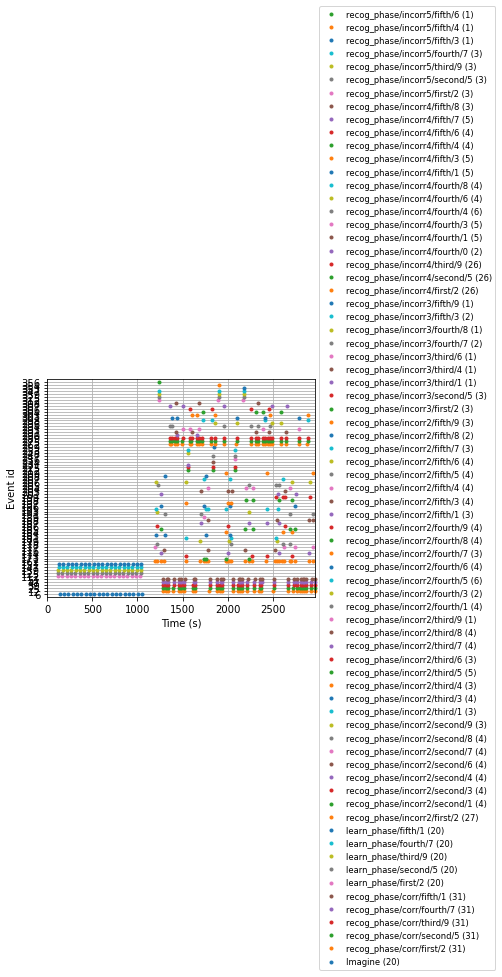

In [156]:
# plotting the events
mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id= event_id );

# Epoching


##### Establishing a time windows to show epochs within
The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [165]:
# establishing time window
tmin, tmax = -0.2, 0.6

# choosing only EEG channels for epoching
picks = mne.pick_types(real_raw.info, meg=False, eeg=True, eog=False)

### Rejecting epochs above or belove threshold 

In [166]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(real_raw, new_triggers[:,:], event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

#disse channels er uden eller over vores threshold (-0.2, 0.5)
# anything above or belove this threshold is likely not brain activity but artefacts
#(reject = dict(eeg=150e-6)) 

Not setting metadata
570 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 570 events and 801 original time points ...
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F3', 'F8', 'FC5', 'FC1', 'FC6', 'T7', 'CP5', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'FC5', 'FC6', 'C3', 'C4']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F7', 'F3', 'F8', 'FC5', 'FC6', 'T7', 'C3', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'F

## Downsampling


In [167]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

## ERPs
Now we can group the epochs by "wrong in 2rd place" and "wrong in 4th place" and take a look at the differences between them!

Overwriting existing file.


/tmp/ipykernel_195/1980427789.py:10: RuntimeWarning: This filename (/work/RikkeUldbæk#3267/fif_files/all_epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_resampled.save('/work/RikkeUldbæk#3267/fif_files/all_epochs_eeg.fif', overwrite= True)


Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


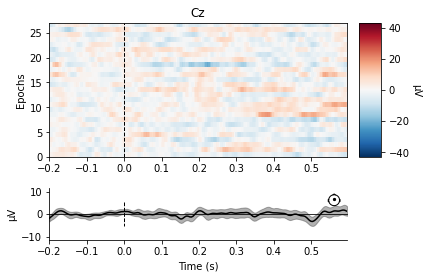

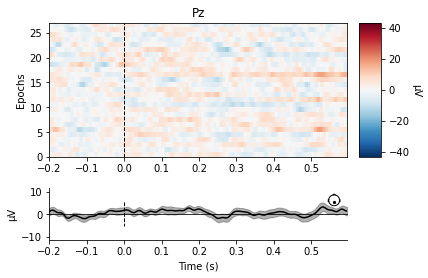

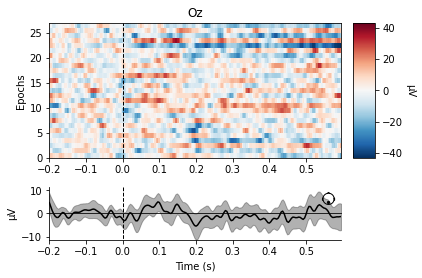

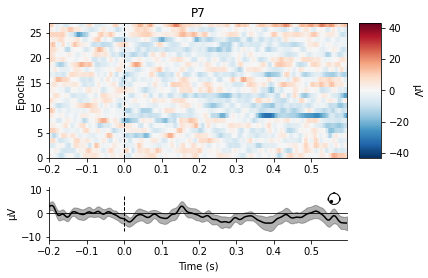

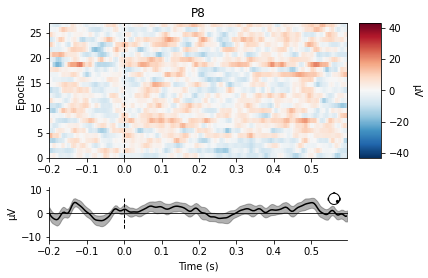

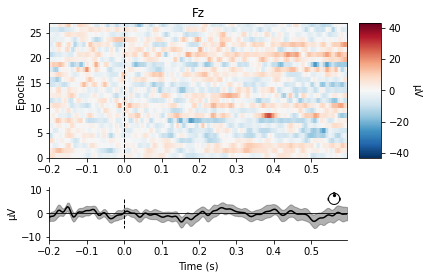

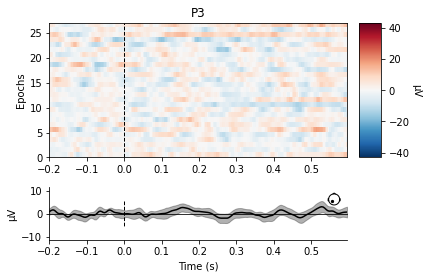

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


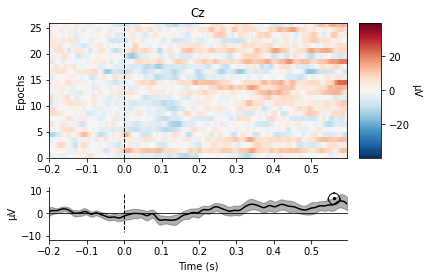

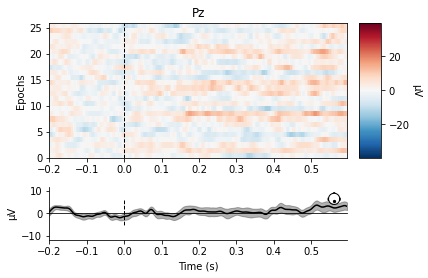

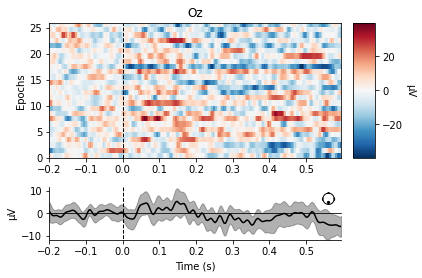

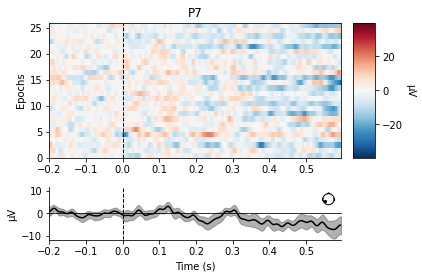

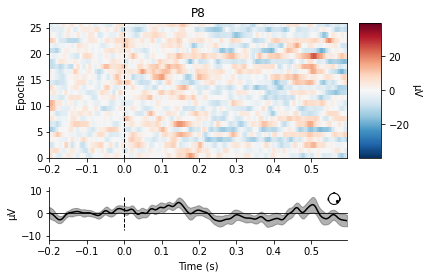

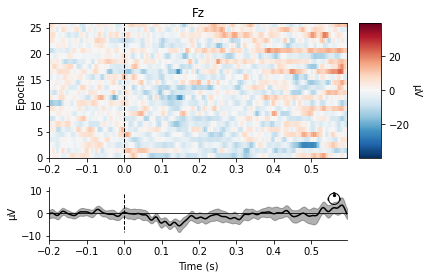

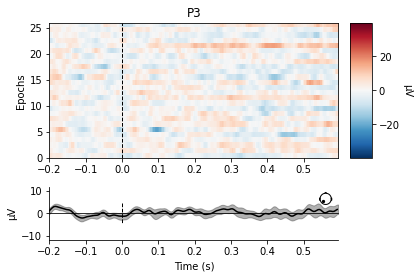

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


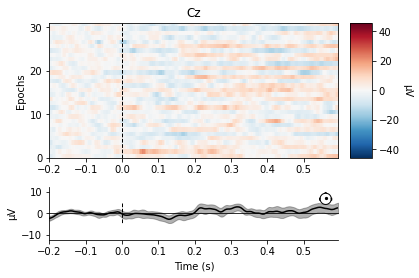

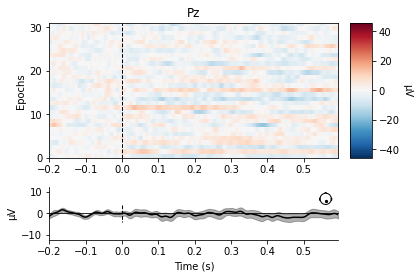

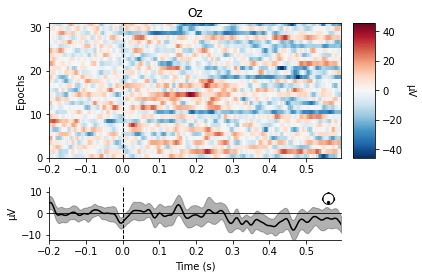

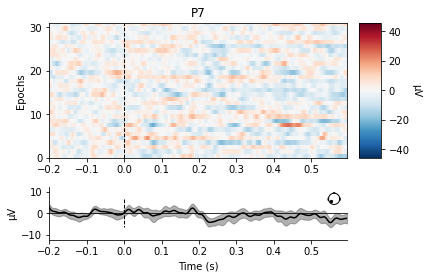

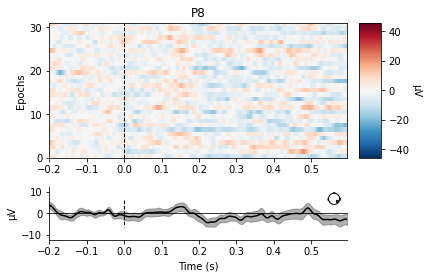

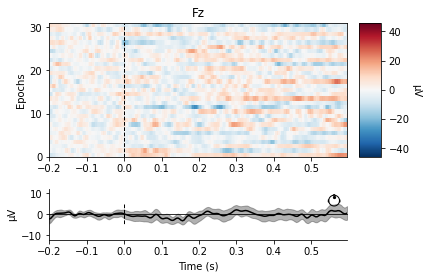

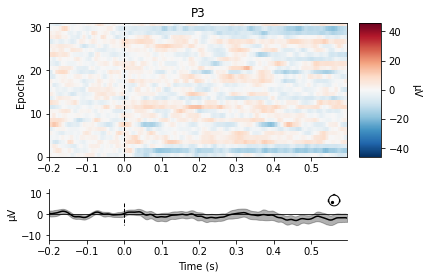

In [169]:
# now the '/' used in the event IDs comes in handy!
#incorrect 
incorr_2 = epochs_resampled['recog_phase/incorr2/second']
incorr_4 = epochs_resampled['recog_phase/incorr4/fourth']

#correct
correct = epochs_resampled['recog_phase/corr/fifth']

###### saving epochs for later analysis #########
epochs_resampled.save('/work/RikkeUldbæk#3267/fif_files/all_epochs_eeg.fif', overwrite= True)

# plotting all channels of interect as an example for each condition
incorr_2.plot_image(picks=['Cz','Pz', 'Oz','P7','P8', 'Fz', 'P3']);
incorr_4.plot_image(picks=['Cz','Pz', 'Oz','P7','P8', 'Fz','P3']);
correct.plot_image(picks=['Cz','Pz', 'Oz','P7','P8', 'Fz','P3']);

### Creating evoked epochs

###### Icorrect 2nd place VS Icorrect 4th place

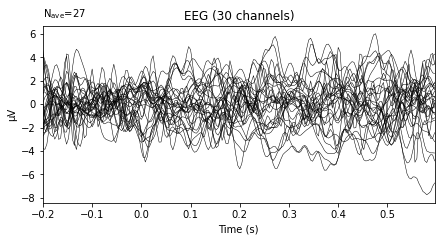

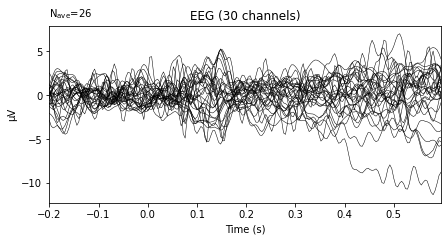

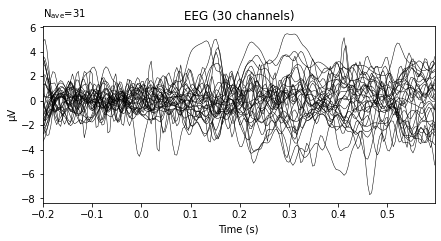

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


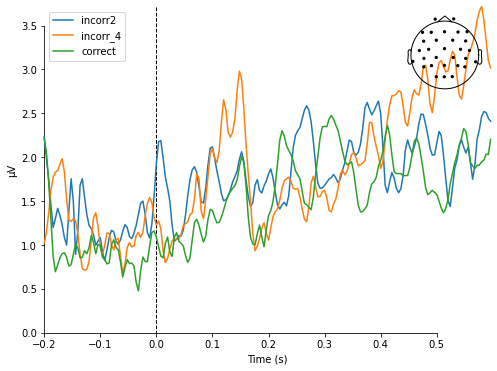

[<Figure size 576x432 with 2 Axes>]

In [161]:
# creating evokeds for incorrect 2nd place
incorr_2_evoked = incorr_2.average()
incorr_2_evoked.plot()

# creating evokeds for incorrect 4th place
incorr_4_evoked = incorr_4.average()
incorr_4_evoked.plot()

# creating evokeds for correct
correct_evoked = correct.average()
correct_evoked.plot()

# Merging the 3 evokeds together
all_evokeds = dict(incorr2=incorr_2_evoked, incorr4= incorr_4_evoked, correct = correct_evoked)

# plotting the two evokeds together
mne.viz.plot_compare_evokeds(dict(incorr2=incorr_2_evoked, incorr_4=incorr_4_evoked, correct = correct_evoked),
                             legend='upper left', show_sensors='upper right')

### More plotting of evoked plots (individually)

No projector specified for this dataset. Please consider the method self.add_proj.


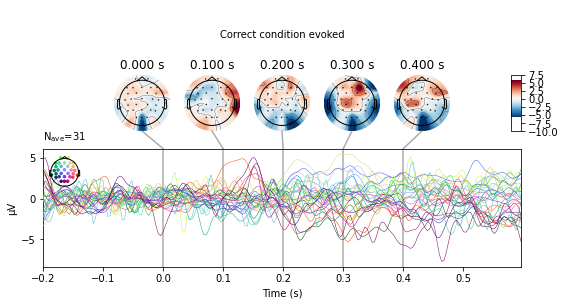

No projector specified for this dataset. Please consider the method self.add_proj.


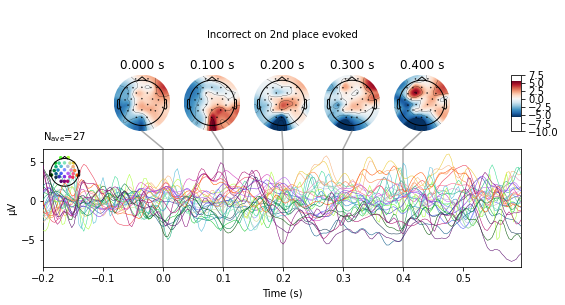

No projector specified for this dataset. Please consider the method self.add_proj.


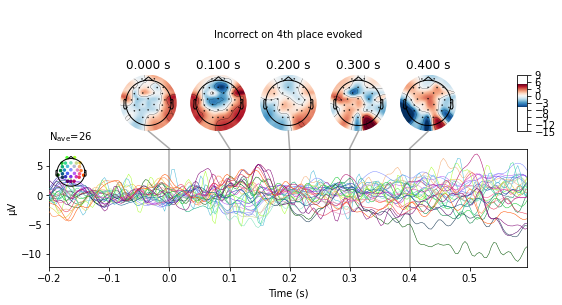

In [162]:
############## for all data
#Evoked Correct
correct_evoked_plot = correct_evoked.plot_joint(picks='eeg', title = "Correct condition evoked", times=[0, 0.1, 0.2, 0.3, 0.4]);

#Evoked Incorrect 3
incorr_2_evoked_plot = incorr_2_evoked.plot_joint(picks='eeg', title = "Incorrect on 2nd place evoked", times=[0, 0.1, 0.2, 0.3, 0.4]);

#Evoked Incorrect 5]
incorr_4_evoked_plot = incorr_4_evoked.plot_joint(picks='eeg', title = "Incorrect on 4th place evoked", times=[0, 0.1, 0.2, 0.3, 0.4]);

##### looking at all P3
#Evoked Incorrect 5]
#plotti = incorr_4_evoked.plot_joint(picks='P3', title = "Incorrect on 4th place evoked for P3");


### Evoked difference in "channel" plot

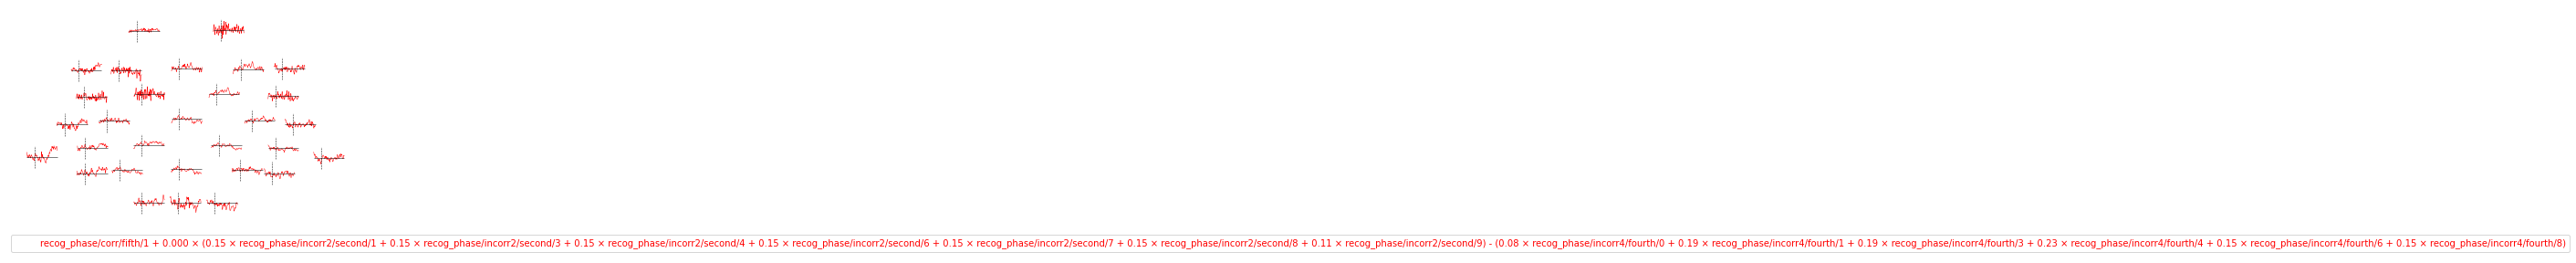

In [163]:
evoked_difference =mne.combine_evoked([correct_evoked, incorr_2_evoked, incorr_4_evoked], weights=[1,0, -1])
evoked_difference.pick_types(eeg = True).plot_topo(color = 'red', legend = True);
                                       

### All evokeds plotted (with mean) 

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


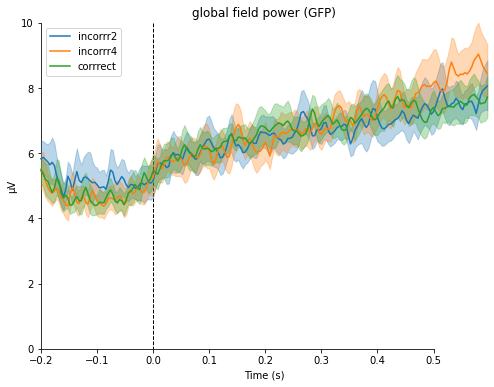

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


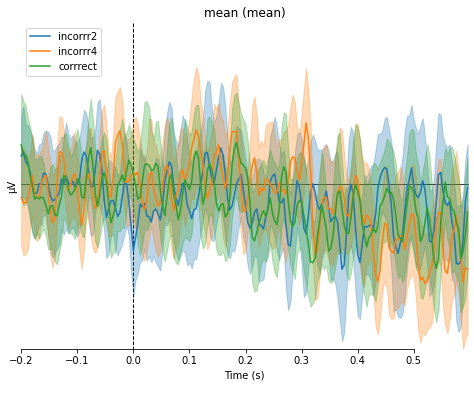

[<Figure size 576x432 with 1 Axes>]

In [164]:
evokeds = dict(incorrr2=list(epochs['recog_phase/incorr2/second'].iter_evoked()),
               incorrr4=list(epochs['recog_phase/incorr4/fourth'].iter_evoked()),
               corrrect=list(epochs['recog_phase/corr/fifth'].iter_evoked()))

mne.viz.plot_compare_evokeds(evokeds, combine='gfp', title="global field power")

mne.viz.plot_compare_evokeds(evokeds, combine='mean', title= "mean")


### Evoked plot for N100 (N1 wave)
N100 or N1 wave
A negative deflection peaking between 90 and 200 msec after the onset of stimulus, is observed when an unexpected stimulus is presented. It is an orienting response or a “matching process,” that is, whenever a stimulus is presented, it is matched with previously experienced stimuli. It has maximum amplitude over Cz and is therefore also called “vertex potential.”


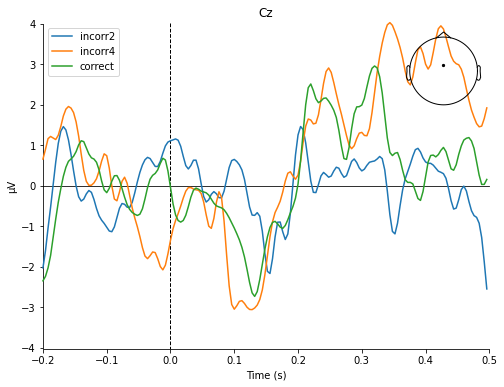

[<Figure size 576x432 with 2 Axes>]

In [114]:
#Plotting all evokeds over Cz
mne.viz.plot_compare_evokeds(all_evokeds, picks='Cz')

#N100_evoked_plot = mne.viz.plot_compare_evokeds(all_evokeds, picks='EEG 0N1')

### Evoked plot for P300

P300 wave is measured in the P3-channel. The P300 wave is an event-related brain potential measured using electroencephalography (EEG). P300 refers to a spike in activity approximately 300ms following presentation of the target stimulus, which is alternated with standard stimuli to create an ‘oddball’ paradigm, which is most commonly auditory. In this paradigm, the subject must respond only to the infrequent target stimulus rather than the frequent standard stimulus. The amplitude of the P300 response is proportional to the amount of attentional resource devoted to the task and the degree of information processing required, while the latency is considered a measure of stimulus classification speed, unrelated to behavioural response time.

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


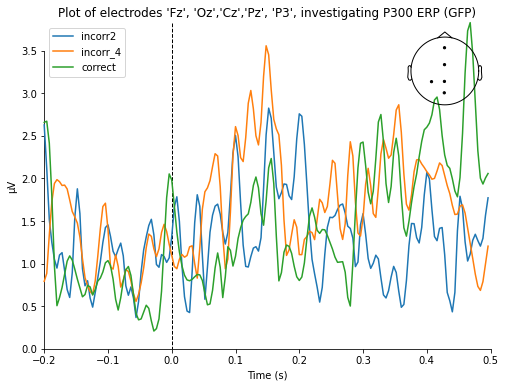

[<Figure size 576x432 with 2 Axes>]

In [120]:
#Plotting all evokeds over P3
mne.viz.plot_compare_evokeds(dict(incorr2=incorr_2_evoked, incorr_4=incorr_4_evoked, correct = correct_evoked),
                             legend='upper left', show_sensors='upper right', picks=['Fz', 'Oz','Cz','Pz', 'P3'], title= "Plot of electrodes 'Fz', 'Oz','Cz','Pz', 'P3', investigating P300 ERP")

### vMMN plot
Electrodes'Pz', 'Oz','P7','P8' were chosen to measure MMN (from Maekawa et. al). 


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


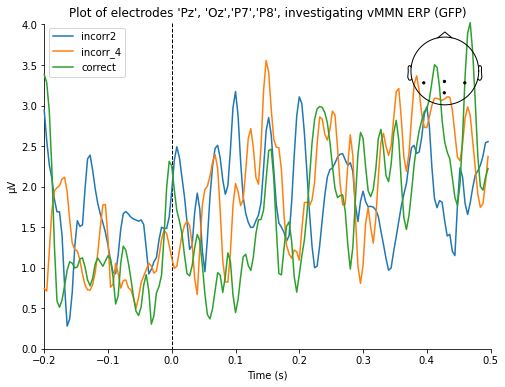

[<Figure size 576x432 with 2 Axes>]

In [118]:
#Plotting all evokeds over 'Pz', 'Oz','P7','P8' (selected channels for MMN)
mne.viz.plot_compare_evokeds(dict(incorr2=incorr_2_evoked, incorr_4=incorr_4_evoked, correct = correct_evoked),
                             legend='upper left', show_sensors='upper right', picks=['Pz', 'Oz','P7','P8'], title= "Plot of electrodes 'Pz', 'Oz','P7','P8', investigating vMMN ERP")

### Digit plot
Plotting the time axis for a whole sequence (1.7 sec)

Not setting metadata
570 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 570 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'C3', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'FC5', 'FC6', 'T7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F3', 'F8', 'FC5', 'FC1', 'FC6', 'T7', 'C3', 'CP5', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'FC5', 'FC6', 'C3', 'C4']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'FC5', 'FC6', 'C3', 'C4']
    Rejecting  

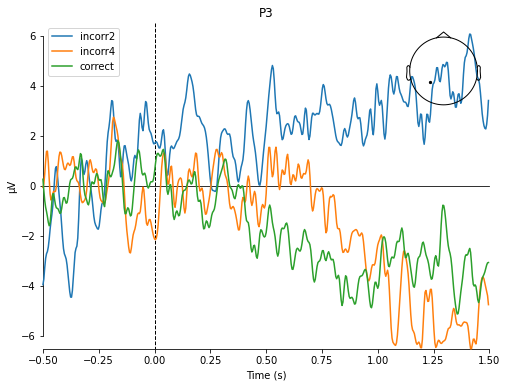

[<Figure size 576x432 with 2 Axes>]

In [75]:
# establishing time window
tmin, tmax = -0.5, 1.5

#new epochs
epochs1 = mne.Epochs(real_raw, new_triggers[:,:], event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

# new resample 
epochs_resampled1 = epochs1.resample(250)


# ERPS
incorr_21 = epochs_resampled1['recog_phase/incorr2/second']
incorr_41 = epochs_resampled1['recog_phase/incorr4/fourth']
correct1 = epochs_resampled1['recog_phase/corr/fifth']


#EVOKING
incorr_2_evoked1 = incorr_21.average()
incorr_4_evoked1 = incorr_41.average()
correct_evoked1 = correct1.average()

# Merging the 3 evokeds together
all_evokeds1 = dict(incorr2=incorr_2_evoked1, incorr4= incorr_4_evoked1, correct = correct_evoked1)

#digit plot
mne.viz.plot_compare_evokeds(all_evokeds1, picks='P3')